# Simulation of Soft Lunar Landing With Fuel Efficiency

## Introduction

What if everything until now has been a prologue? Human progress didn't stop at the 
horizon, then why would it stop at the atmosphere? Space settlement and utilisation is the next link 
in a chain that began with our forebears on land, sailed with them across the seas, and followed 
them into the air. The expanse beyond humanity's cradle beckons our drive to explore and offers us 
visions of a brighter future.

Landing a rocket on the surface of a planet was once a staple of science fiction, but then the lunar 
landing in 1969 of Apollo 11 sparked a whole new generation towards life beyond Earth. However, 
in search of a future outside our home planet, engineers need to come up with solutions to tackle the 
harsh landing surfaces and excessive fuel consumption.

Driven by this fascination, this simulation project uses Pyomo and a simple model of a rocket to compute a control policy for a soft landing, helping further missions. The parameters used correspond for the descent of a typical lunar module on the surface of the moon.

## Required Installations



### For Google Colab:

The following cell installs the necessary packages and solvers on Google Colab. This installation must be done for each Google Colab session. Please make sure the downloaded version of Pyomo is >=5.7.0 to comply with Python 3. 

In [1]:
!pip install pyomo
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
ipopt_executable = '/content/ipopt'

### For MacOS:
  
  On MacOS, uncomment and run the following code to perform a one-time installation.

In [2]:
# !pip install -q pyomo
# !curl https://ampl.com/dl/open/ipopt/ipopt-osx.zip --output ipopt-osx.zip --silent
# !unzip -o -q ipopt-osx
# ipopt_executable = './ipopt'

### For Windows PC:

Pyomo can be installed by executing

    !pip install -q pyomo
    
into a Jupyter notebook cell. An ipopt binary executable is available from [ampl.com](https://ampl.com/products/solvers/open-source/).    

## Necessary Libraries

In [3]:
# import the necessary libraries

import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *
import numpy as np

## Version 1: Constant Mass Model

For a rocket with a mass $m$ in vertical flight at altitude $h$, a momentum balance yields the model

\begin{align*}
m\frac{d^2h}{dt^2} & = - m g + v_eu \\
\end{align*}

where $u$ is the mass flow of propellant and $v_e$ is the velocity of the exhaust relative to the rocket. In this first attempt at modeling and control we will neglect the change in rocket mass due to fuel burn.

A typical lunar module is composed of descent and ascent stages, each containing a rocket engine and associated fuel tanks. The descent stage carried the entire assembly to the lunar surface.  The total mass $m$ in the above model therefore consists of the dry and fuel masses of both stages. For the purpose of analyzing the descent of a lunar module to the lunar surface, the 'dry' mass consists of the total mass of the ascent stage plus the dry mass of the descent stage. 


Let us create a model lunar module for our simulation using arbitrary values for the required parameters as specified below:

In [4]:
# lunar module
mass_ascent_dry = 5000.0          # kg mass of ascent stage without fuel 
mass_ascent_fuel = 3500.0         # kg mass of ascent stage fuel 
mass_descent_dry = 3200.0         # kg mass of descent stage without fuel 
mass_descent_fuel = 12000.0       # kg mass of descent stage fuel 

mass_fuel = mass_descent_fuel
mass_dry = mass_ascent_dry + mass_ascent_fuel + mass_descent_dry
mass_total = mass_dry + mass_fuel

# descent engine characteristics
velocity_exhaust = 4000.0             # m/s velocity of the exhaust relative to the rocket
u_max = 48000.0/velocity_exhaust      # 48000 newtons / exhaust velocity

# landing mission specifications
height_initial = 100000.0      # meters
velocity_initial = 1520        # orbital velocity m/s
g = 1.62                       # m/s**2 gravity on moon

### Ordinary Differential Equation (ODE) Solver for Version 1

The function takes in a Pyomo model, solve the specified ODE using backward scheme and plot the change in height and mass flow of engine over time. 

In [5]:
def solve(model):
  
    # use the Pyomo library to solve the ODE
    TransformationFactory('dae.finite_difference').apply_to(model, nfe=50, scheme='BACKWARD')
    SolverFactory('ipopt', executable=ipopt_executable).solve(model)
    
    # generate the time and the height and mass flow wrt time
    tsim = [t for t in model.t]
    hsim = [model.h[t]() for t in model.t]
    usim = [model.u[t]() for t in model.t]

    fig = plt.figure(figsize=[20,15])

    plt.subplot(2,1,1)
    plt.plot(tsim, hsim)
    plt.title('Altitude wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('meters')

    plt.subplot(2,1,2)
    plt.plot(tsim, usim)
    plt.title('Engine Mass Flow wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')

    plt.show()

### First attempt at a solution

For this first attempt at a solution, we will choose an arbitrary value of 150 seconds for the length of the landing mission.

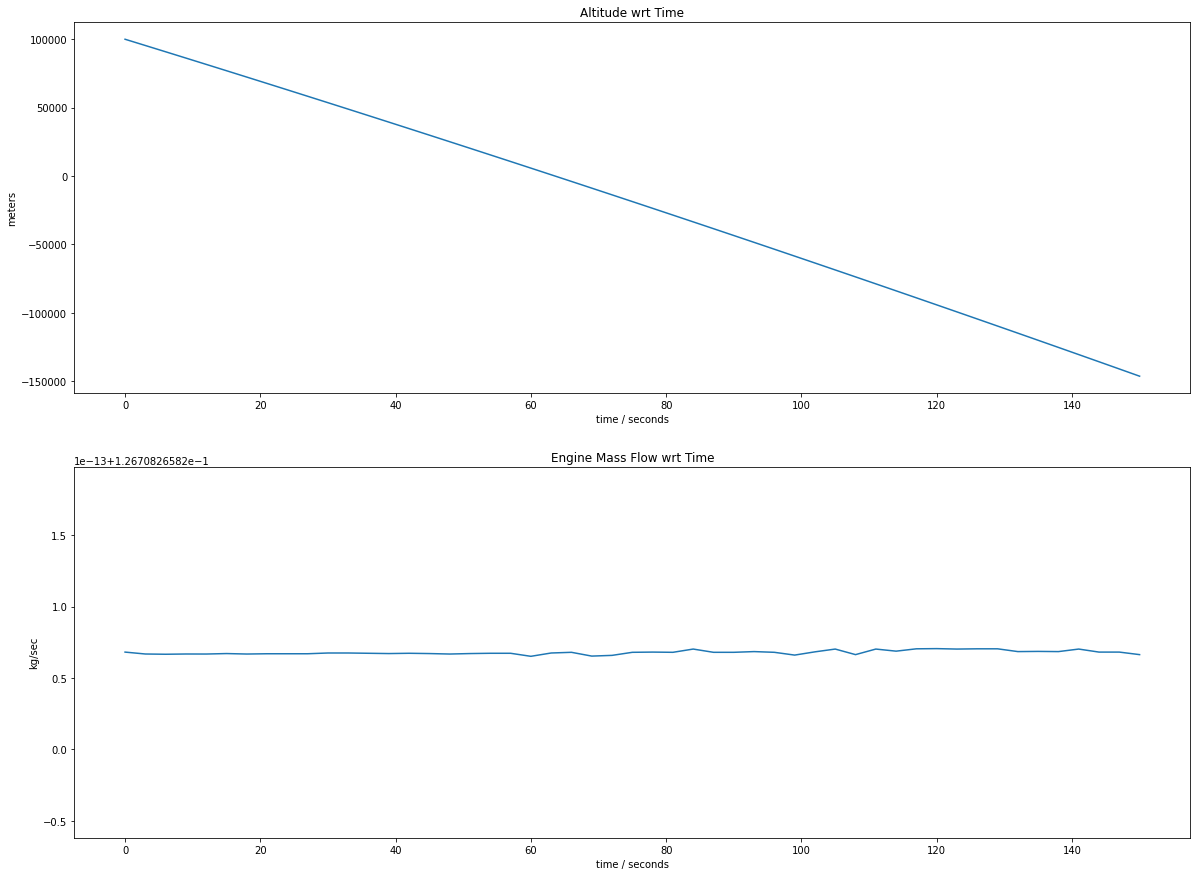

In [6]:
# s time for the simulation to finish
time_finish = 150

# create the model with time, vertical height and mass flow of propellant
model_v1 = ConcreteModel()
model_v1.t = ContinuousSet(bounds=(0, time_finish))
model_v1.h = Var(model_v1.t)
model_v1.u = Var(model_v1.t, domain=NonNegativeReals)

# derivative to find d2h/dt2 = a
model_v1.v = DerivativeVar(model_v1.h, wrt=model_v1.t)
model_v1.a = DerivativeVar(model_v1.v, wrt=model_v1.t)

# build the differential equation with the constraints set in the problem description
model_v1.ode1 = Constraint(model_v1.t, rule = lambda model, t: mass_total*model.a[t] == -mass_total*g + velocity_exhaust*model.u[t])

# set the initial height and velocity
model_v1.h[0].fix(height_initial)
model_v1.v[0].fix(-velocity_initial)

solve(model_v1)

This first attempt at a solution included no specification related to landing on the lunar surface, and so the module **crashes** on the surface about **70s** after the start of the descent since the **engine did not fire**.

### Landing on the Surface

The lunar module has crashed!  It's clear now that we haven't fully specified the desired outcome of the mission.  Let's start by specifying the final condition as being on the surface

$$h(t_f) = 0$$

This condition is implemented in Pyomo by fixing the terminal value of $h$. For this problem, we will also plot the speed of the module as it reaches the surface using a new `solver` function. 

In [7]:
def solve_2(model):
  
    # use the Pyomo library to solve the ODE
    TransformationFactory('dae.finite_difference').apply_to(model, nfe=50, scheme='BACKWARD')
    SolverFactory('ipopt', executable=ipopt_executable).solve(model)
    
    # generate the time and the height, mass flow and speed wrt time
    tsim = [t for t in model.t]
    hsim = [model.h[t]() for t in model.t]
    usim = [model.u[t]() for t in model.t]
    vsim = [-model.v[t]() for t in model.t]

    fig = plt.figure(figsize=[20,15])

    plt.subplot(3,1,1)
    plt.plot(tsim, hsim)
    plt.title('Altitude wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('meters')
    plt.legend([f'Altitude at {tsim[-1]}s = {hsim[-1]} m'])

    plt.subplot(3,1,2)
    plt.plot(tsim, usim)
    plt.title('Engine Mass Flow wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')

    plt.subplot(3,1,3)
    plt.plot(tsim, vsim)
    plt.ylim([0,1600])
    plt.title('Speed wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('meteres/sec')
    plt.legend([f'Speed at {tsim[-1]}s = {round(vsim[-1],1)} m/s'])

    plt.show()

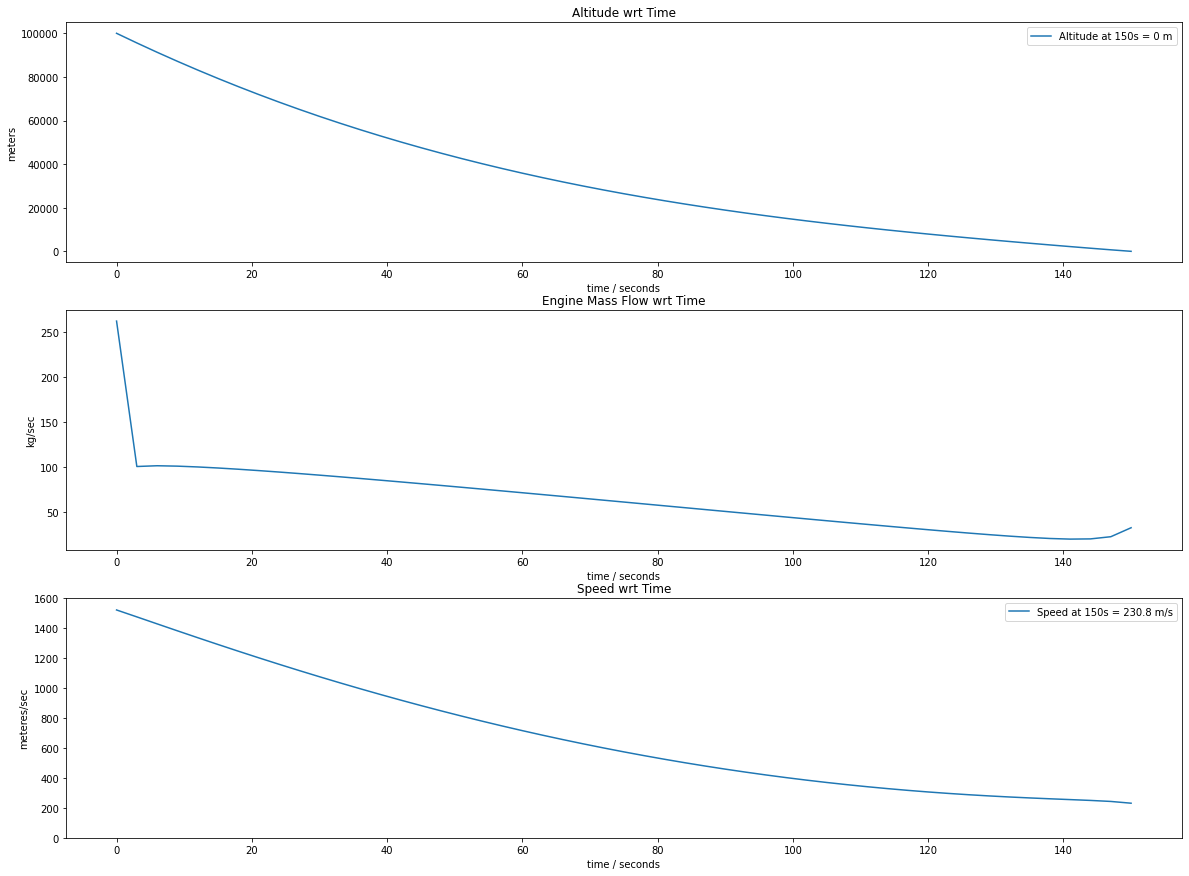

In [8]:
# s time for the simulation to finish
time_finish = 150

model_v1 = ConcreteModel()
model_v1.t = ContinuousSet(bounds=(0, time_finish))
model_v1.h = Var(model_v1.t)
model_v1.u = Var(model_v1.t, domain=NonNegativeReals)

model_v1.v = DerivativeVar(model_v1.h, wrt=model_v1.t)
model_v1.a = DerivativeVar(model_v1.v, wrt=model_v1.t)

model_v1.ode1 = Constraint(model_v1.t, rule = lambda model, t: mass_total*model.a[t] == -mass_total*g + velocity_exhaust*model.u[t])

model_v1.h[0].fix(height_initial)
model_v1.v[0].fix(-velocity_initial)

model_v1.h[time_finish].fix(0)    # land on surface

solve_2(model_v1)

The lunar module now finishes the descent at the lunar surface, but unfortunately arrives with a high velocity of 231m/s and is considered a crash.

### Let's Make a Soft landing

To ensure a soft landing, we also need to specify a terminal velocity, given by:

\begin{align*}
v(t_f) & = 0
\end{align*}

This condition is implemented in Pyomo by fixing the terminal value of $v$ .

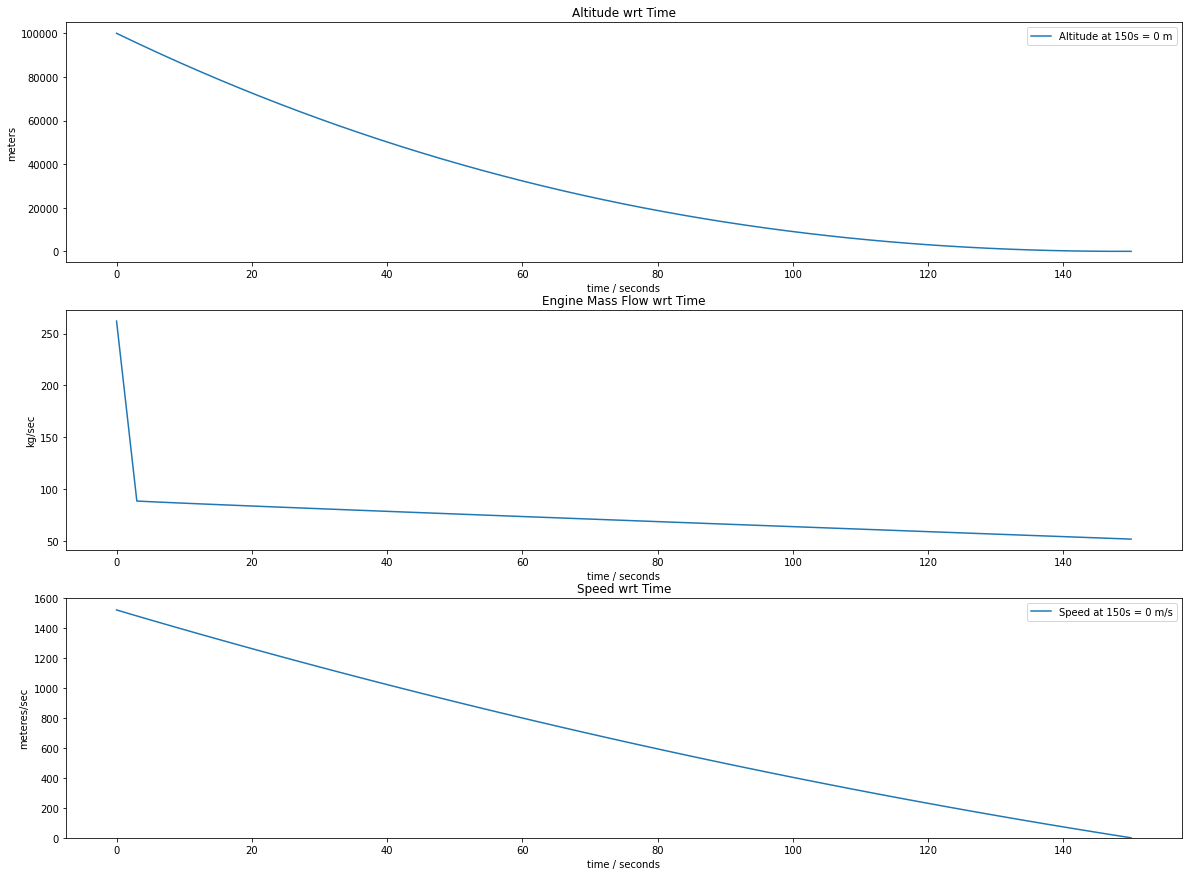

In [9]:
time_finish = 150

model_v1 = ConcreteModel()
model_v1.t = ContinuousSet(bounds=(0, time_finish))
model_v1.h = Var(model_v1.t)
model_v1.u = Var(model_v1.t, domain=NonNegativeReals)

model_v1.v = DerivativeVar(model_v1.h, wrt=model_v1.t)
model_v1.a = DerivativeVar(model_v1.v, wrt=model_v1.t)

model_v1.ode1 = Constraint(model_v1.t, rule = lambda model, t: mass_total*model.a[t] == -mass_total*g + velocity_exhaust*model.u[t])

model_v1.h[0].fix(height_initial)
model_v1.v[0].fix(-velocity_initial)

model_v1.h[time_finish].fix(0)    # land on surface
model_v1.v[time_finish].fix(0)    # soft landing

solve_2(model_v1)

The lunar module is now successfully landing on the lunar surface, but the fuel flow requirement exceeds the maximum capacity (12kg/sec) of the descent engine.

### Restrict Fuel Flow to Engine Capacity

The next step is establish constraints on the control action by limiting fuel flow to the mass flow limits of the descent engine.

$$ 0 \leq u(t) \leq u_{max}$$

Since less thrust is available, we may need to extend the length of the landing mission to find a feasible solution to the optimization problem.

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


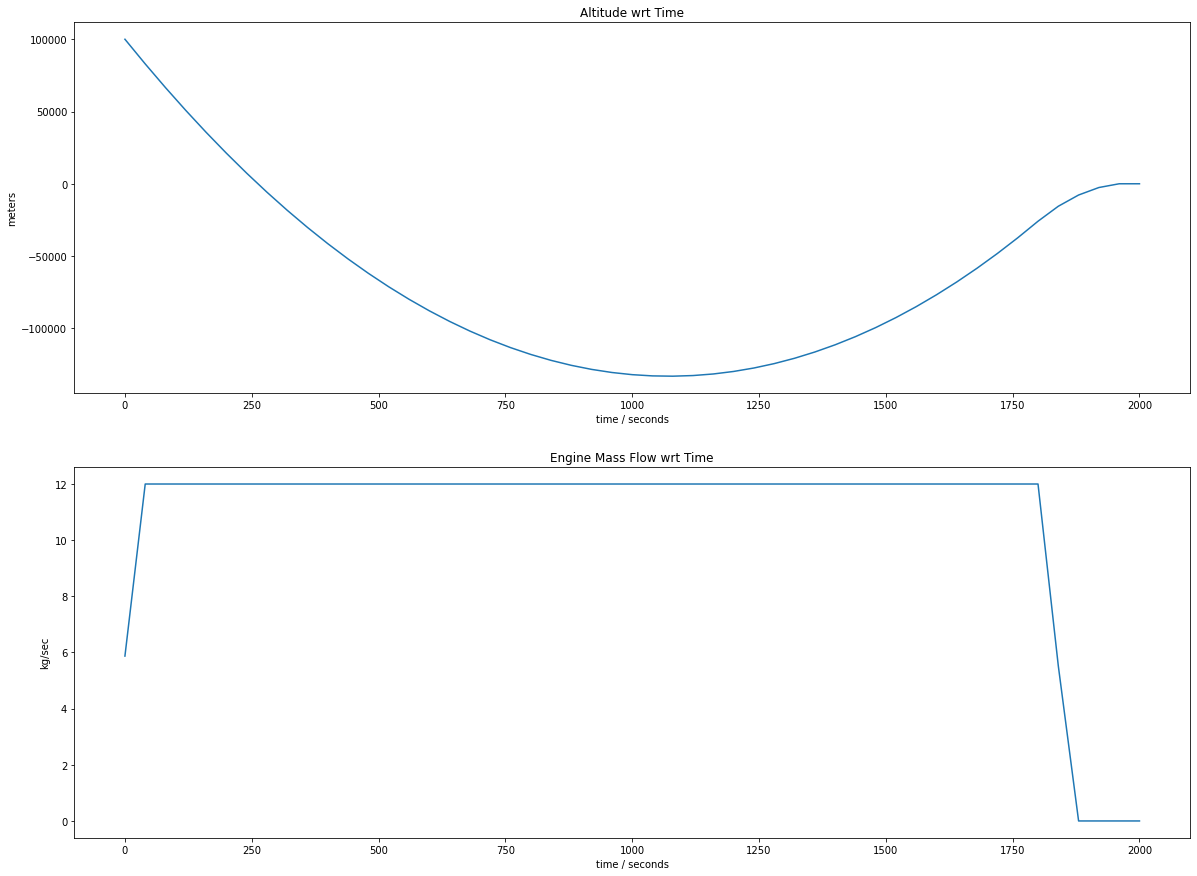

In [10]:
time_finish = 2000

model_v1 = ConcreteModel()
model_v1.t = ContinuousSet(bounds=(0, time_finish))
model_v1.h = Var(model_v1.t)
model_v1.u = Var(model_v1.t, bounds=(0, u_max))

model_v1.v = DerivativeVar(model_v1.h, wrt=model_v1.t)
model_v1.a = DerivativeVar(model_v1.v, wrt=model_v1.t)

model_v1.ode1 = Constraint(model_v1.t, rule = lambda model, t: mass_total*model.a[t] == -mass_total*g + velocity_exhaust*model.u[t])

model_v1.h[0].fix(height_initial)
model_v1.v[0].fix(-velocity_initial)

model_v1.h[time_finish].fix(0)    # land on surface
model_v1.v[time_finish].fix(0)    # soft landing

solve(model_v1)

**Please ignore the ipopt warning in the above results. It is due to the fact that the solver has reached a local minimum while trying to satisfy our fixed constraints which will be fixed later.** 

At this point, it's now clear that the version 1 of this model has run into some serious problems:

* The calculated trajectory takes us through a crash landing and trip through the interior of the moon (negative height). 
* The fixed constraints have caused the solver to reach a local minimum. 
* There is no obvious means of estimating the time required for the mission. 

## Version 2: Rescaled Model

Let's begin with the last issue. We will introduce an additional decision variable $T$ denoting the length of the mission. Time is then rescaled as

$$\tau = \frac{t}{T}\quad\implies\quad t =\tau T$$

The differential equation model then becomes

\begin{align*}
\frac{m}{T^2}\frac{d^2h}{d\tau^2} & = - m g + v_eu \\
\end{align*}

The net result is that an additional variable, $T$, denoting the duration of the descent mission has been introduced into the optimization problem.

### ODE Solver for Version 2

The function takes in a Pyomo model, solves the specified ODE using backward scheme, plots the change in height and mass flow of engine over time, and prints the total time of the descent mission. 

In [11]:
def solve_v2(model):
  
    TransformationFactory('dae.finite_difference').apply_to(model, nfe=50, scheme='BACKWARD')
    SolverFactory('ipopt', executable=ipopt_executable).solve(model)
    
    tsim = [t*model.T() for t in model.t]
    hsim = [model.h[t]() for t in model.t]
    usim = [model.u[t]() for t in model.t]

    fig = plt.figure(figsize=[20,10])

    plt.subplot(2,1,1)
    plt.plot(tsim, hsim)
    plt.title('Altitude wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('meters')
    plt.legend([f'mission length = {(round(model.T(),1))} seconds'])

    plt.subplot(2,1,2)
    plt.plot(tsim, usim)
    plt.title('Engine Mass Flow wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')

    plt.show()

### How Long Does the Mission Take?

Instead of fixing a time for the simulation finish in, we are setting the time as an optimisation factor which will be evaluated using Pyomo while satisfying the final height and velocity constraints. 

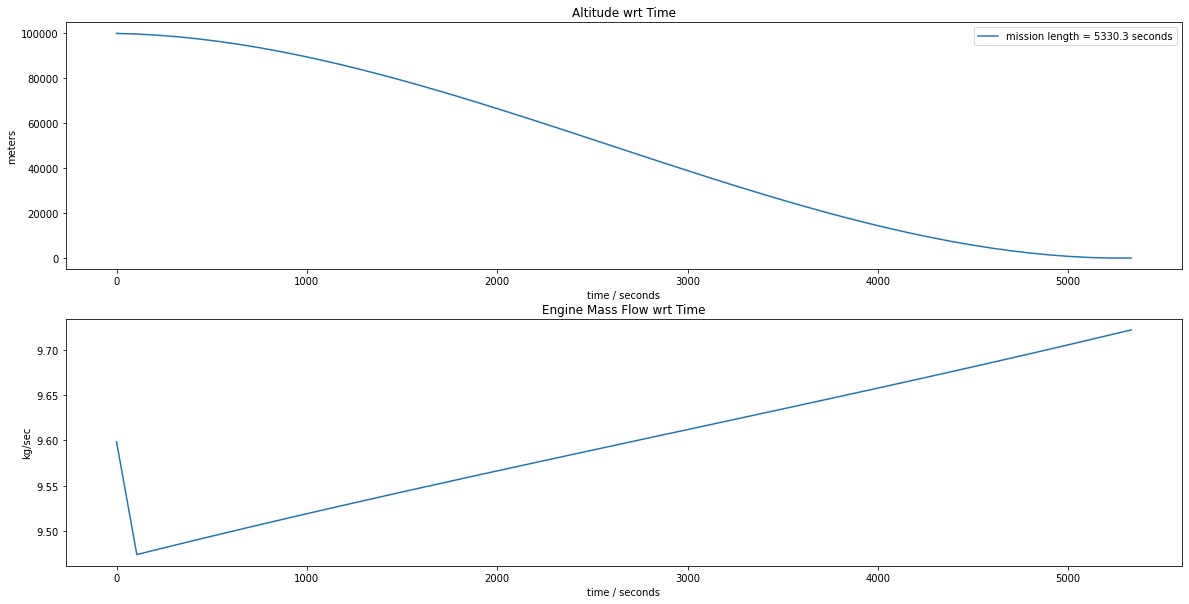

In [12]:
# create the model with time, vertical height and mass flow of propellant
model_v2 = ConcreteModel()
model_v2.t = ContinuousSet(bounds=(0, 1))     # t stands for tau now
model_v2.h = Var(model_v2.t)
model_v2.u = Var(model_v2.t, bounds=(0, u_max))
model_v2.T = Var(domain=NonNegativeReals)

# derivative to find d2h/dt2 = a
model_v2.v = DerivativeVar(model_v2.h, wrt=model_v2.t)
model_v2.a = DerivativeVar(model_v2.v, wrt=model_v2.t)

# build the differential equation with the new constraints set in the problem description
model_v2.ode1 = Constraint(model_v2.t, rule = lambda model, t: 
                           mass_total*model.a[t]/model.T**2 == -mass_total*g + velocity_exhaust*model.u[t])

model_v2.h[0].fix(height_initial)
model_v2.v[0].fix(-velocity_initial)

model_v2.h[1].fix(0)    # land on surface
model_v2.v[1].fix(0)    # soft landing

solve_v2(model_v2)

### How much fuel is burned?

Fuel consumption can be calculated as

\begin{align*}
\mbox{fuel consumed} & = \int_0^T u(t)\,dt  = T \int_0^1u(\tau)\,d\tau
\end{align*}

We will use a modified version of `solve_v2` function to print the fuel consumption. 

In [13]:
def solve_v2_2(model):
    TransformationFactory('dae.finite_difference').apply_to(model, nfe=50, scheme='BACKWARD')
    SolverFactory('ipopt', executable=ipopt_executable).solve(model)
    
    tsim = [t*model.T() for t in model.t]
    hsim = [model.h[t]() for t in model.t]
    usim = [model.u[t]() for t in model.t]

    fig = plt.figure(figsize=[20,10])

    plt.subplot(2,1,1)
    plt.plot(tsim, hsim)
    plt.title('Altitude wrt Time')
    plt.ylabel('meters')
    plt.legend([f'mission length = {(round(model.T(),1))} seconds'])

    plt.subplot(2,1,2)
    plt.plot(tsim, usim)
    plt.title('Engine Mass Flow wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('kg/sec')
    plt.legend([f'fuel burned = {(round(model.fuel(),1))} kg; max fuel available = {mass_descent_fuel} kg'])

    plt.show()

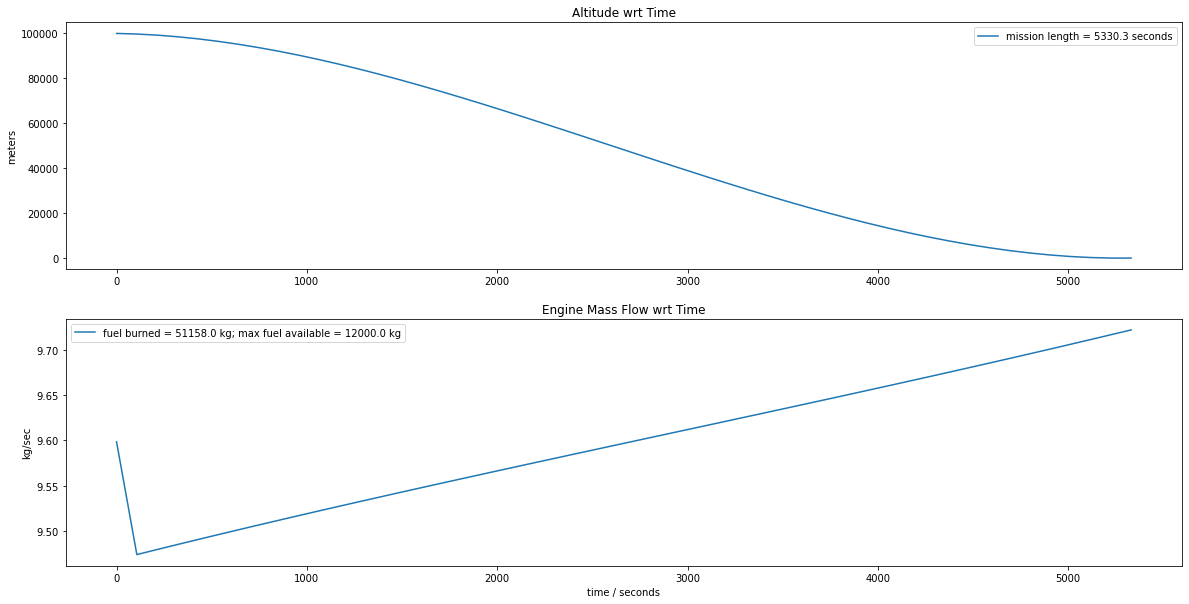

In [14]:
model_v2 = ConcreteModel()
model_v2.t = ContinuousSet(bounds=(0, 1))
model_v2.h = Var(model_v2.t)
model_v2.u = Var(model_v2.t, bounds=(0, u_max))
model_v2.T = Var(domain=NonNegativeReals)

model_v2.v = DerivativeVar(model_v2.h, wrt=model_v2.t)
model_v2.a = DerivativeVar(model_v2.v, wrt=model_v2.t)

model_v2.fuel = Integral(model_v2.t, wrt=model_v2.t, rule = lambda model, t: model.u[t]*model.T)

model_v2.ode1 = Constraint(model_v2.t, rule = lambda model, t: 
    mass_total*model.a[t]/model.T**2 == -mass_total*g + velocity_exhaust*model.u[t])

model_v2.h[0].fix(height_initial)
model_v2.v[0].fix(-velocity_initial)

model_v2.h[1].fix(0)    # land on surface
model_v2.v[1].fix(0)    # soft landing

solve_v2_2(model_v2)

## Version 3: Final Rocket Model

The second version of the model has run into a serious problem because it appears to use way more fuel than that is available. But that may be an artifact of the assumption of constant mass. In our simulation model, the fuel in the descent engine comprises more than 50% of the total mass of the lander.

Hence for this final model, we augment the model with a mass balance for fuel. This yields: 

\begin{align*}
\frac{m(t)}{T^2}\frac{d^2h}{d\tau^2} & = - m(t)g + v_eu \\
\\
\frac{1}{T}\frac{dm}{d\tau} & = -u
\end{align*}

Moreover, we will also incorporate an optimisation to minimise the fuel consumption as:

$$\min_{u(\tau), T} T\int_0^1 u(\tau)\, d\tau$$

### ODE Solver for Version 3

The function takes in a Pyomo model, solves the specified ODE using backward scheme, plots the change in height, mass flow of engine and fuel over time, and prints the total time of the descent mission, total fuel burned and remaining.

In [15]:
def solve_v3(model):
    TransformationFactory('dae.finite_difference').apply_to(model, nfe=50, scheme='BACKWARD')
    SolverFactory('ipopt', executable=ipopt_executable).solve(model)
    
    mass_nonfuel = mass_ascent_dry + mass_ascent_fuel + mass_descent_dry
    
    tsim = [t*model.T() for t in model.t]
    hsim = [model.h[t]() for t in model.t]
    usim = [model.u[t]() for t in model.t]
    fsim = [model.m[t]() - mass_nonfuel for t in model.t]

    fig = plt.figure(figsize=[20,15])

    plt.subplot(3,1,1)
    plt.plot(tsim, hsim)
    plt.title('Altitude wrt Time')
    plt.ylabel('meters')
    plt.legend([f'mission length = {(round(model.T(),1))} seconds'])

    plt.subplot(3,1,2)
    plt.plot(tsim, usim)
    plt.title('Engine Mass Flow wrt Time')
    plt.ylabel('kg/sec')
    plt.legend([f'fuel burned = {(round(model.fuel(),1))} kg'])

    plt.subplot(3,1,3)
    plt.plot(tsim, fsim)
    plt.title('Fuel Remaining wrt Time')
    plt.xlabel('time / seconds')
    plt.ylabel('kg')
    plt.legend([f'fuel remaining = {(round(fsim[-1],1))} kg'])

    plt.show()


At this point we need to worry about nonsensical answers to the optimization for minimum fuel. For this purpose we add upper and lower bounds on $T$ that should restrict the solver to meaningful solutions.

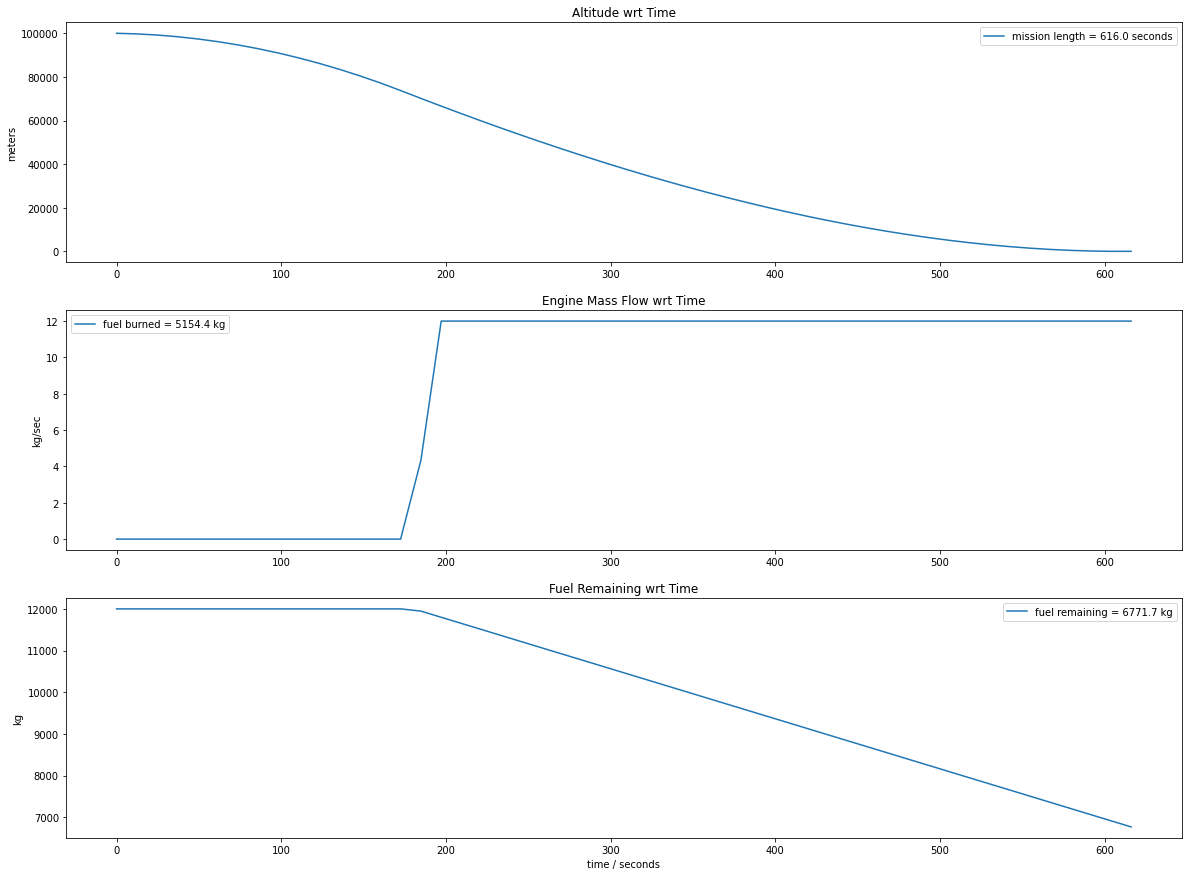

In [16]:
model_v3 = ConcreteModel()
model_v3.t = ContinuousSet(bounds=(0, 1))
model_v3.h = Var(model_v3.t, domain=NonNegativeReals)
model_v3.m = Var(model_v3.t)
model_v3.u = Var(model_v3.t, bounds=(0, u_max))
model_v3.T = Var(bounds=(100,1000))

model_v3.v = DerivativeVar(model_v3.h, wrt=model_v3.t)
model_v3.a = DerivativeVar(model_v3.v, wrt=model_v3.t)
model_v3.mdot = DerivativeVar(model_v3.m, wrt=model_v3.t)    # change of mass wrt time

model_v3.fuel = Integral(model_v3.t, wrt=model_v3.t, rule = lambda model, t: model.u[t]*model.T)
model_v3.obj = Objective(expr=model_v3.fuel, sense=minimize)

model_v3.ode1 = Constraint(model_v3.t, rule = lambda model, t: model.m[t]*model.a[t]/model.T**2 == -model.m[t]*g + velocity_exhaust*model.u[t])  # first ODE to satisfy
model_v3.ode2 = Constraint(model_v3.t, rule = lambda model, t: model.mdot[t]/model.T == -model.u[t])    # second ODE to satisfy

model_v3.h[0].fix(height_initial)
model_v3.v[0].fix(-velocity_initial)
model_v3.m[0].fix(mass_total)

model_v3.h[1].fix(0)    # land on surface
model_v3.v[1].fix(0)    # soft landing

solve_v3(model_v3)

As can be seen the final model yields a descent mission completion time of only 616 seconds and burns only a little above 40% of the total amount of fuel available. 